In [1]:
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
import pickle
import os
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.cluster.hierarchy import fcluster

import scipy
import pylab
import scipy.cluster.hierarchy as sch
from pyensembl import EnsemblRelease
import math
from statsmodels.sandbox.stats.multicomp import multipletests


In [4]:
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'

In [12]:
tissue = 'Breast - Mammary Tissue'
[X_matrix, y_pheno] = pickle.load(open(os.path.join(GTEx_directory, 'data/processed/association_data/expression/inception_50_-1.h5/small/{}/X_y_mean'.format(tissue)),'rb'))

In [13]:
import scipy
import pylab
import scipy.cluster.hierarchy as sch

# Generate random features and distance matrix.

def distance(x,y):
    dist = 1 - pearsonr(x,y)[0]**2
    return dist

D = np.zeros([1024,1024])
for i in range(1024):
    if i%100 == 0:
        print (i)
    for j in range(1024):
        D[i,j] = distance(y_pheno[:,i], y_pheno[:,j])


0
100
200
300
400
500
600
700
800
900
1000


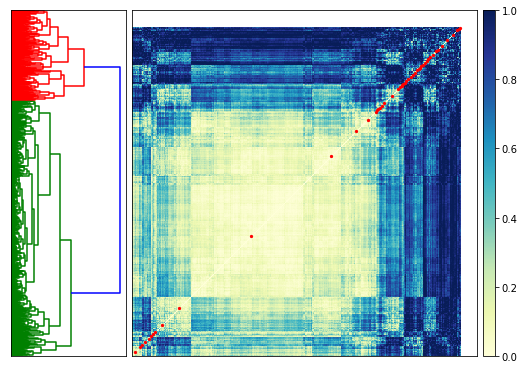

In [14]:

# Generate random features and distance matrix.

Dc = D.copy()
# Compute and plot first dendrogram.
fig = pylab.figure(figsize=(8,8))
ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
Y = sch.linkage(Dc, method='average')
Z1 = sch.dendrogram(Y, orientation='right')
ax1.set_xticks([])
ax1.set_yticks([])

# Compute and plot second dendrogram.
# ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
# Y = sch.linkage(D, method='ward')
# Z2 = sch.dendrogram(Y)
# ax2.set_xticks([])
# ax2.set_yticks([])

# Plot distance matrix.
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
# idx2 = Z2['leaves']
Dc = Dc[idx1,:]
Dc = Dc[:,idx1]
im = axmatrix.matshow(Dc, aspect='auto', origin='lower', cmap='YlGnBu')
axmatrix.set_xticks([])
axmatrix.set_yticks([])

clusters = fcluster(Y,50,criterion='maxclust')

for i in range(50):
    cluster_ids = np.array(range(1024))[(clusters == i+1)[idx1]]
    ID = np.floor((np.max(cluster_ids) - np.min(cluster_ids))/2) + np.min(cluster_ids)
    axmatrix.scatter([ID],[ID],c='red',s=5)

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
pylab.colorbar(im, cax=axcolor)
# fig.show()
# fig.savefig('dendrogram.png')

In [15]:
len(np.array(range(1024))[(clusters == i+1)])

3

In [16]:
#Only interested in these components
representative_features = [int(np.floor(np.median(np.array(range(1024))[(clusters == i+1)]))) for i in range(50)]
representative_features_cluster_sizes = [len(np.array(range(1024))[(clusters == i+1)]) for i in range(50)]

In [17]:
y_pheno[:,representative_features].shape

(175, 50)

In [18]:
tissue = 'Breast - Mammary Tissue'
if tissue == 'Artery - Tibial':
    tissue_filename = 'Artery_Tibial'
elif tissue == 'Heart - Left Ventricle':
    tissue_filename = 'Heart_Left_Ventricle'
elif tissue == 'Breast - Mammary Tissue':
    tissue_filename = 'Breast_Mammary_Tissue'
elif tissue == 'Brain - Cerebellum':
    tissue_filename = 'Brain_Cerebellum'
else:
    tissue_filename = tissue

tissue_expression_filepath = '/nfs/research2/stegle/stegle_secure/GTEx/download/49139/PhenoGenotypeFiles/RootStudyConsentSet_phs000424.GTEx.v6.p1.c1.GRU/ExpressionFiles/phe000006.v2.GTEx_RNAseq.expression-data-matrixfmt.c1/parse_data/44_tissues/GTEx_Data_20150112_RNAseq_RNASeQCv1.1.8_gene_rpkm_{}_normalised_without_inverse_gene_expression.txt'.format(tissue_filename)

with open(tissue_expression_filepath, 'r') as f:
    expression_table = np.array([x.split('\t') for x in f.read().splitlines()])
transcript_IDs = [x.split('.')[0] for x in expression_table[:,0][1:]]
data = EnsemblRelease(77)


gene_functions = []
for (i,ID) in enumerate(transcript_IDs):
    try:
        gene_functions.append(data.gene_by_id(ID).biotype)
    except ValueError:
        gene_functions.append('NA')
    if i % 1000 == 0:
        print (i)

protein_coding_IDs = np.array(transcript_IDs)[np.array(gene_functions) == 'protein_coding']
protein_coding_indexes = np.array([transcript_IDs.index(x) for x in protein_coding_IDs])

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


# Pvalues we care about

In [19]:
p_X_matrix = X_matrix[:,protein_coding_indexes]

filter_limit = 1

filtered_indexes = np.mean(p_X_matrix, axis=0) > filter_limit

f_p_X_matrix = p_X_matrix[:,filtered_indexes]
print (f_p_X_matrix.shape)


f_p_pvalue_indicies = np.array(range(28683))[protein_coding_indexes][filtered_indexes]

f_p_transcript_names = np.array(transcript_IDs)[protein_coding_indexes][filtered_indexes]

(175, 12180)


In [11]:
component = 0
tissue = 'Lung'

# 'data/processed/association_results/expression/inception_50_-1.h5/Lung/mean/component1_sh{}_fl0.py'.format(component)
real_pvalues = np.array(pickle.load(open(GTEx_directory + '/data/processed/association_results/expression/inception_50_-1.h5/small/{}/mean/pvalues/component{}_sh0_fl0.py'.format(tissue,component),'rb'))[1])

In [20]:
# pvalues we care about
print (f_p_pvalue_indicies)
# components we care about
print (representative_features)

[   31    32    33 ..., 27673 27674 27676]
[693, 772, 395, 310, 579, 483, 155, 226, 397, 475, 508, 542, 462, 619, 539, 624, 767, 506, 763, 738, 585, 699, 364, 84, 326, 582, 770, 357, 589, 446, 676, 642, 424, 958, 226, 704, 730, 687, 94, 643, 791, 370, 129, 815, 559, 272, 336, 571, 620, 489]


In [21]:
import seaborn
component = 537
tissue = 'Breast - Mammary Tissue'

# 'data/processed/association_results/expression/inception_50_-1.h5/Lung/mean/component1_sh{}_fl0.py'.format(component)
real_pvalues = np.array(pickle.load(open(GTEx_directory + '/data/processed/association_results/expression/inception_50_-1.h5/small/{}/mean/pvalues/component{}_sh0_fl0.py'.format(tissue,component),'rb'))[1])
f_p_real_pvalues = real_pvalues[f_p_pvalue_indicies]
shuffled_data = pickle.load(open(GTEx_directory + '/data/processed/association_results/expression/inception_50_-1.h5/small/{}/mean/pvalues/component{}_sh1_fl0.py'.format(tissue,component),'rb'))
shuffled_idx = np.array(shuffled_data[0])
shuffled_pvalues = np.array(shuffled_data[1])
f_p_shuffled_pvalues = shuffled_pvalues[f_p_pvalue_indicies]

In [22]:
np.array(X_matrix)[:,protein_coding_indexes][:,filtered_indexes].shape

(175, 12180)

In [23]:
real_representative_feature_pvalues = []
shuffled_representative_feature_pvalues = []
for feature in representative_features:
    real_pvalues = np.array(pickle.load(open(GTEx_directory + '/data/processed/association_results/expression/inception_50_-1.h5/small/{}/mean/pvalues/component{}_sh0_fl0.py'.format(tissue,feature),'rb'))[1])
    f_p_real_pvalues = real_pvalues[f_p_pvalue_indicies]
    shuffled_data = pickle.load(open(GTEx_directory + '/data/processed/association_results/expression/inception_50_-1.h5/small/{}/mean/pvalues/component{}_sh1_fl0.py'.format(tissue,feature),'rb'))
    shuffled_idx = np.array(shuffled_data[0])
    shuffled_pvalues = np.array(shuffled_data[1])
    f_p_shuffled_pvalues = shuffled_pvalues[f_p_pvalue_indicies]

    real_representative_feature_pvalues.append(f_p_real_pvalues)
    shuffled_representative_feature_pvalues.append(f_p_shuffled_pvalues)
    

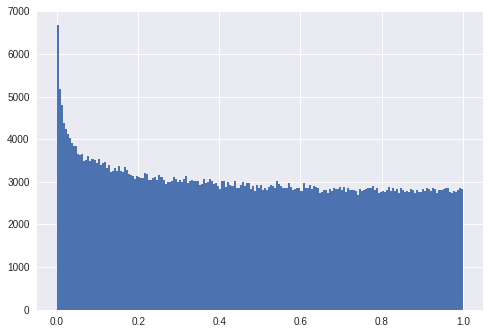

In [24]:
plt.hist(np.array(real_representative_feature_pvalues).flatten(), bins=200)
plt.show()

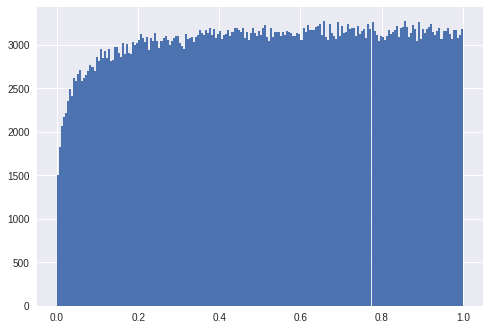

In [25]:
plt.hist(np.array(shuffled_representative_feature_pvalues).flatten(), bins=200)
plt.show()

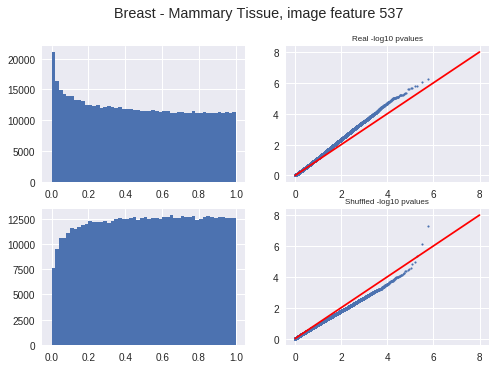

In [26]:
sorted_real_indexes = np.argsort(np.array(real_representative_feature_pvalues).flatten())
sorted_real_pvalues = np.array(real_representative_feature_pvalues).flatten()[sorted_real_indexes]
sorted_shuffled_indexes = np.argsort(np.array(shuffled_representative_feature_pvalues).flatten())
sorted_shuffled_pvalues = np.array(shuffled_representative_feature_pvalues).flatten()[sorted_shuffled_indexes]


sample_real = sorted_real_pvalues
expected_real = np.linspace(1/len(sorted_real_pvalues), 1, len(sorted_real_pvalues))
sample_shuffle = sorted_shuffled_pvalues
expected_shuffle = np.linspace(1/len(sorted_shuffled_pvalues), 1, len(sorted_shuffled_pvalues))

f,a = plt.subplots(2,2)
f.suptitle("{}, image feature {}".format(tissue,component))
a[0][0].hist(np.array(real_representative_feature_pvalues).flatten(), bins=50)
a[1][0].hist(np.array(shuffled_representative_feature_pvalues).flatten(), bins=50)

a[0][1].scatter([-math.log(x,10) for x in expected_real], [-math.log(x,10) for x in sample_real], s=3)
a[0][1].plot(np.linspace(0,8,100), np.linspace(0,8,100), c='red')
a[0][1].set_title('Real -log10 pvalues', size=8)
a[1][1].scatter([-math.log(x, 10) for x in expected_shuffle], [-math.log(x,10) for x in sample_shuffle], s=3)
a[1][1].plot(np.linspace(0,8,100), np.linspace(0,8,100),c='red')
a[1][1].set_title('Shuffled -log10 pvalues', size=8)
plt.show()

In [34]:
representations = []
patches = []
tissue = 'Breast - Mammary Tissue'
for (i,ID) in enumerate(os.listdir(os.path.join(GTEx_directory, 'data/processed/covering_patches/small/Breast - Mammary Tissue/'))[0:10]):
    if i % 1 == 0:
        print (i)
    for batch in os.listdir(os.path.join(GTEx_directory, 'data/processed/covering_patches/small/Breast - Mammary Tissue/',ID)):
        ID = batch.split('_')[0]
        ps = pickle.load(open(os.path.join(GTEx_directory, 'data/processed/covering_patches/small/Breast - Mammary Tissue', ID, batch ), 'rb'))
        if os.path.exists(os.path.join(GTEx_directory, 'data/processed/representations/inception_50_-1.h5/small/Breast - Mammary Tissue', ID, batch )):
#             print (ID, os.path.join(GTEx_directory, 'data/processed/representations/inception_50_-1.h5/small/Lung', ID, batch ))
            rs = pickle.load(open(os.path.join(GTEx_directory, 'data/processed/representations/inception_50_-1.h5/small/Breast - Mammary Tissue', ID, batch ), 'rb'))
            patches.extend(ps)
            representations.extend(rs)


0
1
2
3
4
5
6
7
8
9


In [31]:
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

for i in range(2):
    row_index = multipletests(np.array(real_representative_feature_pvalues).flatten(), method='fdr_bh', alpha=0.05)[0].reshape(50, 12180)[i,:]
    gene_names = [data.gene_by_id(ID).gene_name for ID in  f_p_transcript_names[row_index]]
    

    GO = gp.gprofile(gene_names)
    try:
        GO_description = np.array(GO)[:,-3]
    except IndexError:
        GO_description = []
    
    row_index_numbers = row_index.nonzero()[0]
    k = len(row_index_numbers)
    if k == 0:
        continue
    if k > 3:
        f,a = plt.subplots(2,int(math.ceil(k/2)), figsize=(7*int(math.ceil(k/2)),10))
    else:
        f,a = plt.subplots(1,k, figsize=(7*k,5))
    f.suptitle('Image feature {}, cluster size {}'.format(representative_features[i], representative_features_cluster_sizes[i]),size=15,y=1.05)
    f.text(0.1, -0.1, "GO enrichment: \n" + "\n".join(GO_description),size=10, wrap=True)
    for j in range(k):
        if k == 1:
            axis = a
        else:
            axis = a.flatten()[j]
        axis.scatter(f_p_X_matrix[:, row_index_numbers[j]], y_pheno[:,representative_features[i]],s=3)
        R = pearsonr(f_p_X_matrix[:, row_index_numbers[j]], y_pheno[:,representative_features[i]])
        axis.set_title('Gene: {}, R : {}'.format(gene_names[j], '{:0.2f}'.format(R[0]) ), size=10)
        axis.set_ylabel("Mean activation")
        axis.set_ylim(0,axis.set_ylim()[1])
        axis.set_xlabel("-log10 expression")
        
    top_patches = np.array(patches)[np.argsort(np.array(representations)[:,representative_features[i]])[::-1]]
    f, a = plt.subplots(1,10, figsize=(20,3))
    f.suptitle(i)
    for i in range(10):
        a[i].imshow(top_patches[i])
        a[i].axis('off')

In [38]:
np.array(patches).shape

(0,)

In [32]:
for i in np.random.choice(range(1024),3):
    top_patches = np.array(patches)[np.argsort(np.array(representations)[:,i])[::-1]]
    f, a = plt.subplots(1,5, figsize=(10,3))
    f.suptitle(i)
    for i in range(5):
        a[i].imshow(top_patches[i])
        a[i].axis('off')

IndexError: too many indices for array